# Convolution

In [1]:
import epics
import numpy
import pandas
import torch
import nufft

from statsmodels.api import OLS, WLS

import sys
sys.path.append('..')

from harmonica.util import LENGTH, QX, QZ
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
length = 4096
dtype = torch.float64
device = 'cpu'

# Load data and add noise
win = Window(4096, 'cosine_window', 1.0, dtype=dtype, device=device)
tbt = Data.from_file(54, win, 'virtual_tbt.npy')
std = 1.0E-4*(4.0*torch.rand(54) + 1.0)
Data.add_noise(tbt.data, std)
tbt.reset()

# Reference frequency
ref = 0.461485904416
print(ref)

# Estimate frequency
f = Frequency(tbt)
f('parabola')
print(ref-f.frequency.mean().cpu().item())
print(f.frequency.std().cpu().item())

# Estimate noise
flt = Filter(tbt)
rank, noise = flt.estimate_noise()

# Fit frequency
m, s = f.task_fit(window=True, size=256, mode='ols').T

X = numpy.ones(54).reshape(1, 54).T
y = m.cpu().numpy()
w = (1/s**2).cpu().numpy()

wls = WLS(y, X, w).fit()

print(ref-wls.params.item())
print(wls.bse.item())

0.461485904416
-1.2654278458423818e-07
7.373571183951789e-07
-1.239514486606197e-07
9.754574890228066e-08


In [4]:
print(wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 25 Nov 2021   Prob (F-statistic):                nan
Time:                        14:56:52   Log-Likelihood:                 687.39
No. Observations:                  54   AIC:                            -1373.
Df Residuals:                      53   BIC:                            -1371.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4615   9.75e-08   4.73e+06      0.0

In [5]:
wls = WLS(y, X, w).fit_regularized()
ref - wls.params

array([-1.23951449e-07])

In [48]:
"""
Decomposition module.


"""
class Decomposition():
    
    def __init__(self, data:'Data') -> None:
        pass
        

    @staticmethod
    def fourier(frequency:float, window:torch.Tensor, data:torch.Tensor, *,
                propagate_error:bool=False, std:torch.Tensor=None, std_frequency:float=None) -> tuple:
        """
        Estimate harmonic parameters (and corresponding standard errors) for a given frequency and a batch of signals using (weighted) Fourier sum and direct error propagation.
        
        Note, frequency is treated as an independent random variable in error propagation.
        
        Parameters
        ----------
        frequency: float
            frequency
        window: torch.Tensor
            window
        data: torch.Tensor
            batch of input signals
        propagate_error: bool
            flag to estimate standard errors for parameters
        std: torch.Tensor
            noise sigma for each signal
        std_frequency: float
            frequency sigma

        Returns
        -------
        tuple:
            estimated parameters and standard errors for each signal
            
        """
        dtype = window.dtype
        device = window.device
        
        size = len(data)
        length = len(window)
        
        total = window.sum()
        
        pi = 2.0*torch.acos(torch.zeros(1, dtype=dtype, device=device))
        time = 2.0*pi*torch.linspace(1, length, length, dtype=dtype, device=device)
        
        w_cos = window*torch.cos(frequency*time)
        w_sin = window*torch.sin(frequency*time)
        
        d_cos = w_cos*data[:, :length]
        d_sin = w_sin*data[:, :length]
        
        factor = 2.0/total
        
        c = factor*torch.sum(d_cos, 1)
        s = factor*torch.sum(d_sin, 1)
        a = torch.sqrt(c*c + s*s)
        b = torch.atan2(-s, +c)
            
        param = torch.stack([c, s, a, b]).T
        
        if not propagate_error:
            return (param, None)
        
        std = std**2
        std_frequency = std_frequency**2 if std_frequency != None else None
        
        factor = factor**2
        
        c1a, s1a = c/a, s/a
        c2a, s2a = c1a/a, s1a/a

        dadx = torch.outer(c1a, w_cos) + torch.outer(s1a, w_sin)
        dbdx = torch.outer(s2a, w_cos) - torch.outer(c2a, w_sin)
        
        sigma_c = factor*std*torch.dot(w_cos, w_cos)
        sigma_s = factor*std*torch.dot(w_sin, w_sin)
        sigma_a = factor*std*torch.sum(dadx*dadx, 1)
        sigma_b = factor*std*torch.sum(dbdx*dbdx, 1)
        
        if std_frequency is not None:
            
            dcdf = -torch.sum(time*d_sin, 1)
            dsdf = +torch.sum(time*d_cos, 1)
            
            sigma_c += factor*std_frequency*dcdf**2
            sigma_s += factor*std_frequency*dsdf**2
            sigma_a += factor*std_frequency*(c1a*dcdf + s1a*dsdf)**2
            sigma_b += factor*std_frequency*(c2a*dsdf - s2a*dcdf)**2
            
        sigma_c = torch.sqrt(sigma_c)
        sigma_s = torch.sqrt(sigma_s)
        sigma_a = torch.sqrt(sigma_a)
        sigma_b = torch.sqrt(sigma_b)
        
        sigma = torch.stack([sigma_c, sigma_s, sigma_a, sigma_b]).T

        return (param, sigma)
    
    
    @staticmethod
    def fourier_batched(frequency:torch.Tensor, window:torch.Tensor, data:torch.Tensor, *,
                        propagate_error:bool=False, std:torch.Tensor=None, std_frequency:torch.Tensor=None) -> tuple:
        """
        Estimate harmonic parameters (and corresponding standard errors) for a given batch of frequencies and a batch of signals using (weighted) Fourier sum and direct error propagation.
        
        Note, frequencies are treated as independent random variables in error propagation.
        
        Parameters
        ----------
        frequency: torch.Tensor
            batch of frequencies
        window: torch.Tensor
            window
        data: torch.Tensor
            batch of input signals
        propagate_error: bool
            flag to estimate standard errors for parameters
        std: torch.Tensor
            noise sigma for each signal
        std_frequency: torch.Tensor
            sigma for each frequency

        Returns
        -------
        tuple:
            estimated parameters and standard errors for each signal
            
        """
        dtype = window.dtype
        device = window.device
        
        size = len(data)
        length = len(window)
        
        total = window.sum()
        
        pi = 2.0*torch.acos(torch.zeros(1, dtype=dtype, device=device))
        time = 2.0*pi*torch.linspace(1, length, length, dtype=dtype, device=device)
        
        w_cos = window*torch.cos(frequency.reshape(-1, 1)*time)
        w_sin = window*torch.sin(frequency.reshape(-1, 1)*time)
        
        d_cos = torch.unsqueeze(w_cos, 1)*data[:, :length]
        d_sin = torch.unsqueeze(w_sin, 1)*data[:, :length]
        
        factor = 2.0/total
        
        c = factor*torch.sum(d_cos, -1)
        s = factor*torch.sum(d_sin, -1)
        a = torch.sqrt(c*c + s*s)
        b = torch.atan2(-s, +c)
        
        param = torch.stack([c.T, s.T, a.T, b.T]).T
        
        if not propagate_error:
            return (param, None)
        
        std = std**2
        std_frequency = std_frequency**2 if std_frequency != None else None
        
        factor = factor**2
        
        c1a, s1a = c/a, s/a
        c2a, s2a = c1a/a, s1a/a

        dadx = torch.transpose(torch.unsqueeze(c1a.T, -1)*w_cos + torch.unsqueeze(s1a.T, -1)*w_sin, 0, 1)
        dbdx = torch.transpose(torch.unsqueeze(s2a.T, -1)*w_cos - torch.unsqueeze(c2a.T, -1)*w_sin, 0, 1)
        
        sigma_c = factor*torch.outer(torch.sum(w_cos*w_cos, 1), std)
        sigma_s = factor*torch.outer(torch.sum(w_sin*w_sin, 1), std)
        sigma_a = factor*std*torch.sum(dadx*dadx, -1)
        sigma_b = factor*std*torch.sum(dbdx*dbdx, -1)
        
        if std_frequency is not None:
            
            dcdf = -torch.sum(time*d_sin, -1)
            dsdf = +torch.sum(time*d_cos, -1)
            
            sigma_c += factor*torch.unsqueeze(std_frequency, 1)*dcdf**2
            sigma_s += factor*torch.unsqueeze(std_frequency, 1)*dsdf**2
            sigma_a += factor*torch.unsqueeze(std_frequency, 1)*(c1a*dcdf + s1a*dsdf)**2
            sigma_b += factor*torch.unsqueeze(std_frequency, 1)*(c2a*dsdf - s2a*dcdf)**2
        
        sigma_c = torch.sqrt(sigma_c)
        sigma_s = torch.sqrt(sigma_s)
        sigma_a = torch.sqrt(sigma_a)
        sigma_b = torch.sqrt(sigma_b)
        
        sigma = torch.stack([sigma_c.T, sigma_s.T, sigma_a.T, sigma_b.T]).T

        return (param, sigma)
    
    
    @staticmethod
    def fourier_automatic(frequency:float, window:torch.Tensor, data:torch.Tensor, *,
                          propagate_error:bool=False, std:torch.Tensor=None, std_frequency:float=None) -> tuple:
        """
        Estimate harmonic parameters (and corresponding standard errors) for a given frequency and a batch of signals using (weighted) Fourier sum and automatic error propagation.
        
        Note, frequency is treated as an independent random variable in error propagation (which is not true).
            
        Parameters
        ----------
        frequency: float
            frequency
        window: torch.Tensor
            window
        data: torch.Tensor
            batch of input signals
        propagate_error: bool
            flag to estimate standard errors for parameters
        std: torch.Tensor
            noise sigma for each signal
        std_frequency: float
            frequency sigma
            
        Returns
        -------
        tuple:
            estimated parameters and errors for each signal
            
        """
        dtype = window.dtype
        device = window.device
        size = len(data)
        length = len(window)
        
        total = window.sum()
        
        pi = 2.0*torch.acos(torch.zeros(1, dtype=dtype, device=device))
        time = 2.0*pi*torch.linspace(1, length, length, dtype=dtype, device=device)
        
        if not propagate_error:
            c = 2.0/total*torch.sum(torch.cos(frequency*time)*data[:, :length]*window, 1)
            s = 2.0/total*torch.sum(torch.sin(frequency*time)*data[:, :length]*window, 1)
            a = torch.sqrt(c*c + s*s)
            b = torch.atan2(-s, +c)
            param = torch.stack([c, s, a, b]).T
            return (param, None)
        
        param = []
        sigma = []
        
        length = length + 1

        diagonal = torch.zeros(length, dtype=dtype, device=device)
        diagonal[-1] = std_frequency**2 if std_frequency else 0.0
        
        frequency = torch.tensor(frequency, dtype=dtype, device=device)
        frequency.requires_grad_(propagate_error)
        
        w_cos = 2.0/total*window*torch.cos(frequency*time)
        w_sin = 2.0/total*window*torch.sin(frequency*time)
            
        for idx, signal in enumerate(data[:, :length]):
                        
            diagonal[range(length-1)] = std[idx]**2
            
            signal.requires_grad_(True)
            
            c = torch.sum(w_cos*signal)
            s = torch.sum(w_sin*signal)
            a = torch.sqrt(c*c + s*s)
            b = torch.atan2(-s, +c)
            
            c.backward(retain_graph=True)
            grad = torch.hstack([signal.grad, frequency.grad])
            sigma_c = torch.sqrt(torch.sum(grad*diagonal*grad))
            signal.grad = None
            frequency.grad = None
            
            s.backward(retain_graph=True)
            grad = torch.hstack([signal.grad, frequency.grad])
            sigma_s = torch.sqrt(torch.sum(grad*diagonal*grad))
            signal.grad = None
            frequency.grad = None
            
            a.backward(retain_graph=True)
            grad = torch.hstack([signal.grad, frequency.grad])
            sigma_a = torch.sqrt(torch.sum(grad*diagonal*grad))
            signal.grad = None
            frequency.grad = None
            
            b.backward(retain_graph=True)
            grad = torch.hstack([signal.grad, frequency.grad])
            sigma_b = torch.sqrt(torch.sum(grad*diagonal*grad))
            signal.grad = None
            frequency.grad = None
            
            param.append(torch.stack([c, s, a, b]).detach())            
            sigma.append(torch.stack([sigma_c, sigma_s, sigma_a, sigma_b]))
            
        param = torch.stack(param)
        sigma = torch.stack(sigma)
        return (param, sigma)

In [46]:
w = Window.from_cosine(512, 1.0, dtype=torch.float64, device='cpu')
s = torch.tensor([0.05, 0.01], dtype=w.dtype, device=w.device)
x1 = torch.stack(
    [
        (0.25*torch.cos(2.0*numpy.pi*0.12*torch.linspace(1, w.length, w.length, dtype=w.dtype, device=w.device) + 0.1)),
        (0.75*torch.cos(2.0*numpy.pi*0.12*torch.linspace(1, w.length, w.length, dtype=w.dtype, device=w.device) + 0.6))
    ]
)
x2 = torch.stack(
    [
        (0.1*torch.cos(2.0*numpy.pi*0.24*torch.linspace(1, w.length, w.length, dtype=w.dtype, device=w.device) + 0.25)),
        (0.25*torch.cos(2.0*numpy.pi*0.24*torch.linspace(1, w.length, w.length, dtype=w.dtype, device=w.device) + 0.15))
    ]
)
x3 = torch.stack(
    [
        (0.05*torch.cos(2.0*numpy.pi*0.36*torch.linspace(1, w.length, w.length, dtype=w.dtype, device=w.device) + 0.1)),
        (0.01*torch.cos(2.0*numpy.pi*0.36*torch.linspace(1, w.length, w.length, dtype=w.dtype, device=w.device) + 0.5))
    ]
)

param1a, sigma1a = Decomposition.fourier_automatic(0.12, w.data, x1+x2+x3, propagate_error=True, std=s, std_frequency=1.0E-5)
param1b, sigma1b = Decomposition.fourier_automatic(0.24, w.data, x1+x2+x3, propagate_error=True, std=s, std_frequency=1.0E-5)
param1c, sigma1c = Decomposition.fourier_automatic(0.36, w.data, x1+x2+x3, propagate_error=True, std=s, std_frequency=1.0E-5)

param2a, sigma2a = Decomposition.fourier(0.12, w.data, x1+x2+x3, propagate_error=True, std=s, std_frequency=1.0E-5)
param2b, sigma2b = Decomposition.fourier(0.24, w.data, x1+x2+x3, propagate_error=True, std=s, std_frequency=1.0E-5)
param2c, sigma2c = Decomposition.fourier(0.36, w.data, x1+x2+x3, propagate_error=True, std=s, std_frequency=1.0E-5)

param_x = torch.stack([param2a, param2b, param2c])
sigma_x = torch.stack([sigma2a, sigma2b, sigma2c])

param_y, sigma_y = Decomposition.fourier_batched(
    torch.tensor([0.12, 0.24, 0.36], dtype=w.dtype, device=w.device),
    w.data, x1+x2+x3, propagate_error=True, std=s,
    std_frequency=torch.tensor([1.0E-5, 1.0E-5, 1.0E-5], dtype=w.dtype, device=w.device))

sigma_x - sigma_y

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.]]], dtype=torch.float64)

In [ ]:
# compute for a batch of frequencies? seems unnecessary...
# pass frequency object to decomposition? no, better create it inside...


# problem, for error estimation, frequency sigma is considered independent of signals (not true)

# problem, errors for optics, seems the same problem as in amplitude present (again, if frequency is independent, wich in no true)

# next on the menu for fourier estimation

# 1. 'subtract' (one signal at a time, since 'next' frequencies are not the same)
# estimate frequency (using n turns)
# estimate frequency error (shifts or standard, can use Decomposition function, loop over grid, not sure)
# estimate parameters and errors
# subtrac and repeat (compare res to errors)
# compare amplitudes, identify frequencies
# return dict with some usefull info

# 2. 'dictionary' fit
# frequencies are precomputed (compute basis with errors, compute harmonics with erros (autodiff))
# compute parameters for each in freq dict, again need batched version to avoid python loop
# errors, sort, residual

# 3. correction loop, util for generation of harmonics from pars (see Data)
# residuals, normal, autocorrelation?

# 4. autocorrelation, estimation of noise from decomposition residual

# Example-01: Estimation of parameters

In [76]:
# Estimate parameters and standard error (fixed exact frequency)

# Set parameters
length = 1024
dtype = torch.float64
device = 'cpu'

# Set window
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Set noise parameters
s_x = torch.tensor([0.05, 0.01], dtype=dtype, device=device)
s_f = None

# Set data
t = torch.linspace(1, length, length, dtype=dtype, device=device)
x = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.1), 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.5)])

# Estimate parameters and errors (direct)
param1, sigma1 = Decomposition.fourier(0.12, w.data, x, propagate_error=True, std=s_x, std_frequency=s_f)

# Estimate parameters and errors (automatic)
param2, sigma2 = Decomposition.fourier_automatic(0.12, w.data, x, propagate_error=True, std=s_x, std_frequency=s_f)

# Estimate errors (average over noise realizations)
sigma = []
for _ in range(8192):
    x_n = torch.zeros_like(x) + x
    Data.add_noise(x_n, s_x)
    data, _ = Decomposition.fourier(0.12, w.data, x_n)
    sigma.append(data)
    
sigma = torch.stack(sigma).T.std(-1).T

# Compare parameters
print(param1)
print(param2)

# Compare errors
print(sigma1)
print(sigma2)
print(sigma)

tensor([[2.487510436681e-01, -2.495835146667e-02, 2.500000020678e-01, 9.999998833585e-02],
        [6.581869247589e-01, -3.595691437625e-01, 7.499999980464e-01, 4.999999859401e-01]],
       dtype=torch.float64)
tensor([[2.487510436681e-01, -2.495835146667e-02, 2.500000020678e-01, 9.999998833585e-02],
        [6.581869247589e-01, -3.595691437625e-01, 7.499999980464e-01, 4.999999859401e-01]],
       dtype=torch.float64)
tensor([[2.706329386825e-03, 2.706329386827e-03, 2.706329386826e-03, 1.082531745777e-02],
        [5.412658773651e-04, 5.412658773655e-04, 5.412658773653e-04, 7.216878383668e-04]],
       dtype=torch.float64)
tensor([[2.706329386825e-03, 2.706329386827e-03, 2.706329386826e-03, 1.082531745777e-02],
        [5.412658773651e-04, 5.412658773655e-04, 5.412658773653e-04, 7.216878383668e-04]],
       dtype=torch.float64)
tensor([[2.712322761021e-03, 2.720382151380e-03, 2.711147869273e-03, 1.088760086617e-02],
        [5.433303144860e-04, 5.437639314298e-04, 5.405065924323e-04, 7

In [77]:
# Estimate parameters and standard error (random frequency)

# Set parameters
length = 1024
dtype = torch.float64
device = 'cpu'

# Set window
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Set noise parameters
s_x = torch.tensor([0.05, 0.01], dtype=dtype, device=device)
s_f = 1.0E-5

# Set data
t = torch.linspace(1, length, length, dtype=dtype, device=device)
x = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.1), 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.5)])

# Estimate parameters and errors (direct)
param1, sigma1 = Decomposition.fourier(0.12, w.data, x, propagate_error=True, std=s_x, std_frequency=s_f)

# Estimate parameters and errors (automatic)
param2, sigma2 = Decomposition.fourier_automatic(0.12, w.data, x, propagate_error=True, std=s_x, std_frequency=s_f)

# Estimate errors (average over noise realizations)
err = []
for _ in range(8192):
    x_n = torch.zeros_like(x) + x
    Data.add_noise(x_n, s_x)
    data, _ = Decomposition.fourier(0.12 + 1.0E-5*torch.randn(1, dtype=dtype, device=device), w.data, x_n)
    err.append(data)
    
err = torch.stack(err).T.std(-1).T

# Compare parameters
print(param1)
print(param2)

# Compare errors
print(sigma1)
print(sigma2)
print(err)

tensor([[2.487510436681e-01, -2.495835146667e-02, 2.500000020678e-01, 9.999998833585e-02],
        [6.581869247589e-01, -3.595691437625e-01, 7.499999980464e-01, 4.999999859401e-01]],
       dtype=torch.float64)
tensor([[2.487510436681e-01, -2.495835146667e-02, 2.500000020678e-01, 9.999998833585e-02],
        [6.581869247589e-01, -3.595691437625e-01, 7.499999980464e-01, 4.999999859401e-01]],
       dtype=torch.float64)
tensor([[2.823366849364e-03, 8.462351009487e-03, 2.706329386826e-03, 3.400201524111e-02],
        [1.160253091832e-02, 2.122207165559e-02, 5.412658773653e-04, 3.224081838943e-02]],
       dtype=torch.float64)
tensor([[2.823366849364e-03, 8.462351009487e-03, 2.706329386826e-03, 3.400201524111e-02],
        [1.160253091832e-02, 2.122207165559e-02, 5.412658773653e-04, 3.224081838943e-02]],
       dtype=torch.float64)
tensor([[2.834841752485e-03, 8.419118476373e-03, 2.706564506373e-03, 3.386017002269e-02],
        [1.158611678201e-02, 2.113964695977e-02, 5.431666499512e-04, 3

# Example-02: Estimation of parameters (batched frequency)

In [101]:
# Estimate parameters and errors for a batch of frequencies

# Set parameters
length = 1024
dtype = torch.float64
device = 'cpu'

# Set window
w = Window.from_cosine(length, 1.0, dtype=torch.float64, device='cpu')

# Set noise parameters
s_x = torch.tensor([0.05, 0.01], dtype=dtype, device=device)
s_f = 1.0E-5

# Set data
t = torch.linspace(1, length, length, dtype=dtype, device=device)
x1 = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.10), 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.60)])
x2 = torch.stack([0.10*torch.cos(2.0*numpy.pi*0.24*t + 0.25), 0.25*torch.cos(2.0*numpy.pi*0.24*t + 0.15)])
x3 = torch.stack([0.05*torch.cos(2.0*numpy.pi*0.36*t + 0.10), 0.01*torch.cos(2.0*numpy.pi*0.36*t + 0.50)])
x = x1 + x2 + x3

# Compute parameters and errors for each frequency (direct)
param1a, sigma1a = Decomposition.fourier(0.12, w.data, x, propagate_error=True, std=s_x, std_frequency=s_f)
param1b, sigma1b = Decomposition.fourier(0.24, w.data, x, propagate_error=True, std=s_x, std_frequency=s_f)
param1c, sigma1c = Decomposition.fourier(0.36, w.data, x, propagate_error=True, std=s_x, std_frequency=s_f)
param1 = torch.stack([param1a, param1b, param1c])
sigma1 = torch.stack([sigma1a, sigma1b, sigma1c])

# Compute parameters and errors for each frequency (automatic)
param2a, sigma2a = Decomposition.fourier_automatic(0.12, w.data, x, propagate_error=True, std=s_x, std_frequency=s_f)
param2b, sigma2b = Decomposition.fourier_automatic(0.24, w.data, x, propagate_error=True, std=s_x, std_frequency=s_f)
param2c, sigma2c = Decomposition.fourier_automatic(0.36, w.data, x, propagate_error=True, std=s_x, std_frequency=s_f)
param2 = torch.stack([param2a, param2b, param2c])
sigma2 = torch.stack([sigma2a, sigma2b, sigma2c])

# Compute parameters and errors for all frequencies
param3, sigma3 = Decomposition.fourier_batched(
    torch.tensor([0.12, 0.24, 0.36], dtype=dtype, device=device),
    w.data,
    x,
    propagate_error=True,
    std=s_x,
    std_frequency=torch.tensor([s_f, s_f, s_f], dtype=dtype, device=device))

# Compare errors
print(sigma1)
print(sigma2)
print(sigma3)

tensor([[[2.823367006540e-03, 8.462350872370e-03, 2.706329386826e-03, 3.400201408633e-02],
         [1.366070896174e-02, 1.995946154519e-02, 5.412658773673e-04, 3.224081851439e-02]],

        [[2.821372831761e-03, 4.132527963440e-03, 2.706329386827e-03, 4.208765530916e-02],
         [1.320249347921e-03, 7.986066271173e-03, 5.412658773785e-04, 3.230537287583e-02]],

        [[2.711107856128e-03, 3.145744093177e-03, 2.706329386826e-03, 6.299710870531e-02],
         [5.628928320903e-04, 6.107240353067e-04, 5.412658773666e-04, 6.299696800443e-02]]],
       dtype=torch.float64)
tensor([[[2.823367006540e-03, 8.462350872370e-03, 2.706329386826e-03, 3.400201408633e-02],
         [1.366070896174e-02, 1.995946154519e-02, 5.412658773673e-04, 3.224081851439e-02]],

        [[2.821372831761e-03, 4.132527963440e-03, 2.706329386827e-03, 4.208765530916e-02],
         [1.320249347921e-03, 7.986066271173e-03, 5.412658773785e-04, 3.230537287583e-02]],

        [[2.711107856128e-03, 3.145744093177e-03, 2.

In [136]:
# Estimate parameters for a list of harmonics

# Set parameters
length = 2048
dtype = torch.float64
device = 'cpu'

# Set window
w = Window.from_cosine(length, 4.0, dtype=torch.float64, device='cpu')

# Set data
t = torch.linspace(1, length, length, dtype=dtype, device=device)
x1 = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.10)])
x2 = torch.stack([0.10*torch.cos(2.0*numpy.pi*0.24*t + 0.25)])
x3 = torch.stack([0.05*torch.cos(2.0*numpy.pi*0.36*t + 0.10)])
x = x1 + x2 + x3

# Set harmonics
f = 0.12
h = torch.tensor([*Frequency.harmonics(10, [f]).values()], dtype=dtype, device=device)

# Estimate parameters
param, _ = Decomposition.fourier_batched(h, w.data, x, propagate_error=False)

# Result (amplitude)
*_, a, _ = param.T
print(a.T)

tensor([[2.500000000000e-01],
        [1.000000000000e-01],
        [5.000000000000e-02],
        [1.400195522472e-15],
        [3.246578511251e-16],
        [7.230409600856e-16],
        [1.910625572673e-15],
        [5.165559768651e-17],
        [8.345788043923e-16],
        [4.179679039357e-16]], dtype=torch.float64)


# Decomposition-1

In [ ]:
# RPCA/PCA/HANKEL/DMD/ICA ...

# ENVELOPE

# PRONY

# ICA from sklearn

In [ ]:
# Dictionary fit (L2/L1/orthogonal matching pursuit/see sklearn to)

# SCIPY -- nonlinear fit? AIC? BIC?

In [ ]:
# Decomposition (main)

# Frequencies are 'external'

# Computation of parameters

# Convolution

# no need to worry about number of components
# but number of components can be estimated with optimal SVD truncation
# can test residual, can identify harmonics, can track harmonic amplitude decay rate

# note, fundamental frequencies == largest frequencies are a lot more accurate

# convolution is sensetive to frequency error, limited by number of turns, decoherence

# convolution is differentiable, can estimate standard errors
# for errors mostly sigma_x is relevant, but can add sigma_f

# normal loop: compute--subtract--repeat

# convolution is somewhat robust wrt noise (not spikes?)

# filter effect (filter befor decomposition)

# circle? remove all but 1st, better 1st?

# correction (laskar), works well for known number of components without noise, can be usefull?

# nonliner correction, fit with good initials, AIC, BIC

# LS fit for known number of components? can use weights

# incorporate envelope?

# PRONY?

# OLS, WLS, nonlinear fit, prony, ..., pinv

# DICTIONARY fit

# filter -- fit? -- > dmd -- decomposition

# complex data? (now frequecny computation only for real)

# aoutoregression

# Frequency fit

In [90]:
# Import

import epics
import numpy
import pandas
import torch
import nufft

from harmonica.util import LIMIT, LENGTH, QX, QZ
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [91]:
# Set window
w = Window(4096, 'cosine_window', 1.0, dtype=torch.float64)

# Load test TbT data
tbt = Data.from_file(54, w, 'virtual_tbt.npy')

f = Frequency(tbt)
f('parabola')
ref = f.frequency.mean()


w = Window(1024, 'cosine_window', 1.0, dtype=torch.float64)
tbt = Data.from_tensor(w, tbt.data[:, :1024])

# Add random noise to data
std = 1.0E-4 * torch.ones(54, dtype=torch.float64)
Data.add_noise(tbt.data, std)
tbt.reset()

# ADD EXTRA NOISE
std[0] = 5.0E-3
tbt.data[0].add_(std[0]*torch.randn(tbt.length)) ;
tbt.reset()

In [92]:
f = Frequency(tbt)
f('parabola')
print(f.frequency.mean().item())
print(f.frequency.median().item())
print(f.frequency.std().item())

0.46148663854900435
0.46148570013186757
8.158417327193965e-06


In [93]:
print(ref - f.frequency.mean())
print(ref - f.frequency.median())

tensor(-7.341328083221e-07, dtype=torch.float64)
tensor(2.042843284533e-07, dtype=torch.float64)


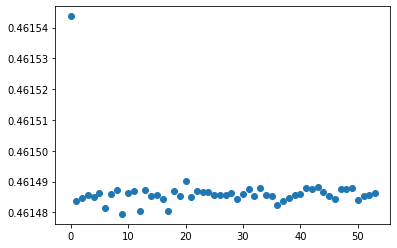

In [94]:
plt.scatter(range(54), f.frequency)
plt.show()

In [95]:
out = f.task_fit(size=32)
print(out[:, 0].mean().item())
print(out[:, 0].std().item())
print(min(out[:, 1]))
print(max(out[:, 1]))

0.46148663790219546
8.15364470541516e-06
tensor(5.323001849353e-06, dtype=torch.float64)
tensor(8.690175021405e-05, dtype=torch.float64)


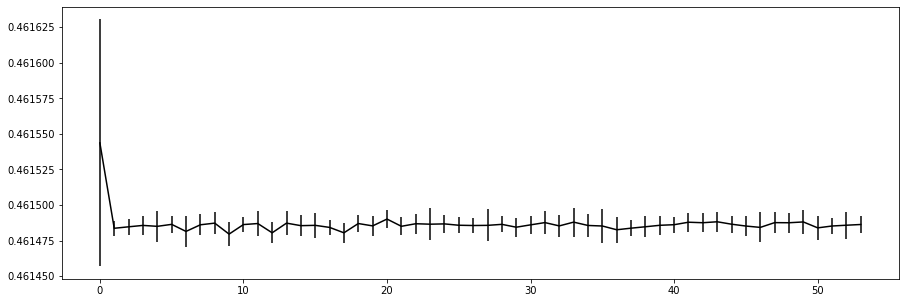

In [96]:
plt.figure(figsize=(15, 5))
plt.errorbar(range(54), out[:, 0], yerr=out[:, 1], c='black')
plt.show()

In [97]:
out = f.task_fit(size=32, mode='wls', std=std)
print(out[:, 0].mean().item())
print(out[:, 0].std().item())
print(min(out[:, 1]))
print(max(out[:, 1]))

0.4614866379024351
8.153647647831918e-06
tensor(5.440802303649e-06, dtype=torch.float64)
tensor(8.698651146362e-05, dtype=torch.float64)


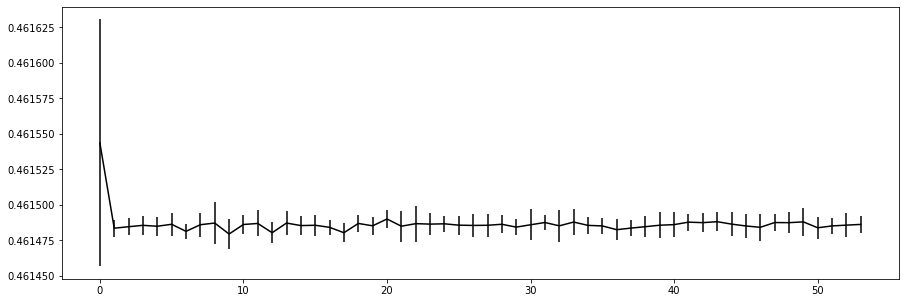

In [98]:
plt.figure(figsize=(15, 5))
plt.errorbar(range(54), out[:, 0], yerr=out[:, 1], c='black')
plt.show()

In [99]:
# fit line with and without weights
# out = OLS(y, X).fit() if mode == 'ols' else WLS(y, X, weights=numpy.array(w)).fit()
from statsmodels.api import OLS, WLS

In [100]:
X = numpy.ones(54).reshape(1, 54).T
y = f.frequency.cpu().numpy()
w = (1/out[:, 1]**2).cpu().numpy()

ols = OLS(y, X).fit()
wls = WLS(y, X, w).fit()

print(ref.item())
print(ols.params.item())
print(wls.params.item())

print(ref.item()-ols.params.item())
print(ref.item()-wls.params.item())
print(ref.item()-f.frequency.mean().item())

0.461485904416196
0.4614866385490043
0.46148551900784424
-7.341328082666188e-07
3.854083517884632e-07
-7.341328083221299e-07


In [101]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 17 Nov 2021   Prob (F-statistic):                nan
Time:                        14:41:42   Log-Likelihood:                 556.57
No. Observations:                  54   AIC:                            -1111.
Df Residuals:                      53   BIC:                            -1109.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4615   1.11e-06   4.16e+05      0.0

In [102]:
# note std is beter comparet to ols
print(wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 17 Nov 2021   Prob (F-statistic):                nan
Time:                        14:41:45   Log-Likelihood:                 624.82
No. Observations:                  54   AIC:                            -1248.
Df Residuals:                      53   BIC:                            -1246.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4615   2.89e-07    1.6e+06      0.0

In [ ]:
# ADD P-T-P comparison 1024+64
# compare ptp with above

# Selection of size (# of points) is not obvious...

In [112]:
class Frequency():
    """
    Returns
    ----------
    Frequency class instance.

    Frequency(data:'Data', *, pad:int=0, f_range:tuple=(0.0, 0.5), fraction:float=2.0)

    Parameters
    ----------
    data: 'Data'
        Data instance.
    pad: int
        Padded length.
        Pad zeros for FFT spectrum and frequency computation.
    f_range: tuple
        Frequency range used for initial frequency guess location.
        FFT frequency estimation range.
    fraction: float
        FFRFT frequency range fraction in units of FFT bin size (one over signal length).

    Attributes
    ----------
    data: 'Data'
        Data instance.
    size: int
        Number of signals.
    length: int
        Signal length.
    dtype: torch.dtype
        Data type.
    cdtype: torch.dtype
        Complex data type.
    device: torch.device
        Device.
    pad: int
        Padded length.
    f_min: float
        Min frequency.
    f_max: float
        Max frequency.
    fft_grid: torch.Tensor
        FFT grid frequencies.
    fft_step: torch.Tensor
        FFT frequency step (bin size, one over signal length).
    fft_spectrum: torch.Tensor
        FFT amplitude spectrum.
    fft_min_bin: int
        FFT bin closest to f_min.
    fft_max_bin: int
        FFT bin closest to f_max.
    fft_min: torch.Tensor
        FFT frequency closest to f_min.
    fft_max: torch.Tensor
        FFT frequency closest to f_max.
    fft_bin: torch.Tensor
        Max FFT bins for all signals.
    fft_frequency: torch.Tensor
        FFT frequency estimation for all signals.
    ffrft_flag: bool
        FFRFT initialization flag.
    ffrft_start: torch.Tensor
        FFRFT starting frequencies for all signals.
        By default FFT frequency estimations are used. i.e. might be different across signals.
    ffrft_span: float
        FFRFT frequency range (same for all signals).
    ffrft_range: torch.Tensor
        FFRFT auxiliary.
    ffrft_data: torch.Tensor
        FFRFT auxiliary.
    ffrft_trig: torch.Tensor
        FFRFT auxiliary.
    ffrft_work: torch.Tensor
        FFRFT auxiliary.
    ffrft_table: torch.Tensor
        FFRFT data.
    ffrft_spectrum: torch.Tensor
        FFRFT amplitude spectum.
    ffrft_bin: torch.Tensor
        FFRFT max bin for all signals.
    ffrft_frequency: torch.Tensor
        FFRFT frequency estimation for all signals.
    parabola_bin: torch.Tensor
        Parabola max 'bin' for all signals.
    parabola_frequency: torch.Tensor
        Parabola frequency estimation for all signals.
    frequency: torch.Tensor
        Frequency estimation for all signals (method dependent).

    Methods
    ----------
    fft_get_spectrum(self) -> None
        Compute FFT amplitude spectrum.
    fft_get_frequency(self, *, f_range:tuple=(None, None)) -> None
        Compute FFT frequency estimation with optional frequency range.
    ffrft_set(length:int, span:float, trig:torch.Tensor, work:torch.Tensor) -> None
        FFRFT auxiliary data initialization (staticmethod).
    ffrft_get(length:int, data:torch.Tensor, trig:torch.Tensor, work:torch.Tensor, table:torch.Tensor) -> None
        FFRFT computation (staticmethod).
    ffrft_set_spectrum(self, *, span:float=None) -> None
        FFRFT auxiliary data initialization.
    ffrft_get_spectrum(self, *, center:float=None, span:float=None) -> None
        Compute FFRFT amplitude spectrum for given central frequency and span.
    ffrft_get_grid(self, idx:int=0) -> torch.Tensor
        Compute FFRFT frequency grid for given signal index.
        Frequency grid might be different across signals if starting frequencies are different.
    ffrft_get_frequency(self) -> None
        Compute FFRFT frequency estimation.
    parabola_get_frequency(self) -> None
        Compute parabola frequency estimation.
    task_fft(self, *, reload:bool=False, window:bool=True, f_range:tuple=(None, None), shift:int=0, count:int=LIMIT) -> None
        Compute spectrum (FFT) and frequency estimation using FFT.
        Optionaly reload TbT data (if epics), apply window and pass other parameters.
    task_ffrft(self, *, reload:bool=False, window:bool=True, f_range:tuple=(None, None), center:float=None, span:float=None, shift:int=0, count:int=LIMIT) -> None
        Compute spectrum (FFT & FFRFT) and frequency estimation using FFRFT.
        Optionaly reload TbT data (if epics), apply window and pass other parameters.
    task_parabola(self, *, reload:bool=False, window:bool=True, f_range:tuple=(None, None), center:float=None, span:float=None, shift:int=0, count:int=LIMIT) -> None
        Compute spectrum (FFT & FFRFT) and frequency estimation using parabola.
        Optionaly reload TbT data (if epics), apply window and pass other parameters.
    task_mean_spectrum(self, *, window:bool=False, log:bool=False) -> tuple
        Compure mean normalized spectrum.
        Computed FFT spectra are normalized using estimated frequencies and averaged over TbT signals.
    task_mixed_spectrum(self, *, length:int=1024, window:bool=True, f_range:tuple=(None, None), name:str='cosine_window', order:float=1.0, normalize:bool=True, position:list=None, log:bool=False) -> tuple
        Compute normalized mixed spectrum for given range.
    task_mixed_frequency(self, *, length:int=1024, window:bool=True, f_range:tuple=(None, None), name:str='cosine_window', order:float=1.0, position:list=None) -> torch.Tensor
        Estimate frequency using mixed TbT data.
    __repr__(self) -> str
        String representation.
    __call__(self, task='parabola', *, reload:bool=False, window:bool=True, f_range:tuple=(None, None), center:float=None, span:float=None, shift:int=0, count:int=LIMIT) -> None
        Compute spectrum and frequency using selected method.
        Optionaly reload TbT data (if epics), apply window and pass other parameters.
    mod(x: float, y:float, d:float=0.0) -> float
        Return the remainder on division of x by y with offset d.
    harmonics(cls, order:int, basis:list, *, limit:float=1.0, offset:float=-0.5) -> dict
        Generate list of harmonics up to given order for list of given basis frequencies.
    identify(cls, order:int, basis:list, frequencies:list, *, limit:float=1.0, offset:float=-0.5) -> dict
        Identify list of frequencies up to maximum order for given frequency basis.

    """

    def __init__(self, data:'Data', *, pad:int=0, f_range:tuple=(0.0, 0.5), fraction:float=2.0) -> None:
        self.data = data
        self.size = data.size
        self.length = data.length
        self.dtype = self.data.dtype
        self.cdtype = (1j*torch.tensor(1, dtype=self.dtype)).dtype
        self.device = self.data.device
        self.pi = 2.0*torch.acos(torch.zeros(1, dtype=self.dtype, device=self.device))
        self.pad = pad if pad else self.length
        self.f_min, self.f_max = f_range
        self.fft_grid = torch.fft.rfftfreq(self.pad, dtype=self.dtype, device=self.device)
        self.fft_step = torch.tensor(1.0/self.pad, dtype=self.dtype, device=self.device)
        self.fft_spectrum = torch.zeros((self.size, len(self.fft_grid)), dtype=self.dtype, device=self.device)
        self.fft_min_bin = torch.floor(self.f_min/self.fft_step).to(torch.long).item()
        self.fft_max_bin = torch.floor(self.f_max/self.fft_step).to(torch.long).item()
        self.fft_min = self.fft_step*self.fft_min_bin
        self.fft_max = self.fft_step*self.fft_max_bin
        self.fft_bin = torch.zeros(self.size, dtype=self.dtype, device=self.device)
        self.fft_frequency = torch.zeros(self.size, dtype=self.dtype, device=self.device)
        self.ffrft_flag = False
        self.ffrft_start = torch.zeros(self.size, dtype=self.dtype, device=self.device)
        self.ffrft_span = fraction/self.length
        self.ffrft_range = torch.linspace(0.0, self.length - 1.0, self.length, dtype=self.dtype, device=self.device)
        self.ffrft_data = torch.zeros((self.size, self.length), dtype=self.cdtype, device=self.device)
        self.ffrft_trig = torch.zeros(self.length, dtype=self.cdtype, device=self.device)
        self.ffrft_work = torch.zeros(2*self.length, dtype=self.cdtype, device=self.device)
        self.ffrft_table = torch.zeros((self.size, 2*self.length), dtype=self.cdtype, device=self.device)
        self.ffrft_spectrum = torch.zeros((self.size, self.length), dtype=self.dtype, device=self.device)
        self.ffrft_bin = torch.zeros(self.size, dtype=self.dtype, device=self.device)
        self.ffrft_frequency = torch.zeros(self.size, dtype=self.dtype, device=self.device)
        self.parabola_bin = torch.zeros(self.size, dtype=self.dtype, device=self.device)
        self.parabola_frequency = torch.zeros(self.size, dtype=self.dtype, device=self.device)
        self.frequency = torch.zeros(self.size, dtype=self.dtype, device=self.device)


    def fft_get_spectrum(self) -> None:
        """
        Compute FFT amplitude spectrum.

        Modify fft_spectrum container.

        """
        torch.abs(torch.fft.rfft(self.data.work, self.pad), out=self.fft_spectrum)


    def fft_get_frequency(self, *, f_range:tuple=(None, None)) -> None:
        """
        Compute FFT frequency estimation with optional frequency range.

        Modify fft_frequency container.

        Parameters
        ----------
        f_range: tuple
            frequency range in (0.0, 0.5)

        Returns
        -------
        None

        """
        if f_range == (None, None):
            self.fft_bin.copy_(self.fft_min_bin + torch.argmax(self.fft_spectrum[:, self.fft_min_bin:self.fft_max_bin], 1))
            self.fft_frequency.copy_(self.fft_step*self.fft_bin)
            return

        self.f_min, self.f_max = f_range
        self.fft_min_bin = torch.floor(self.f_min/self.fft_step).to(torch.long).item()
        self.fft_max_bin = torch.floor(self.f_max/self.fft_step).to(torch.long).item()
        self.fft_min = self.fft_step*self.fft_min_bin
        self.fft_max = self.fft_step*self.fft_max_bin
        self.fft_get_frequency()


    @staticmethod
    def ffrft_set(length:int, span:float, trig:torch.Tensor, work:torch.Tensor) -> None:
        """
        FFRFT auxiliary data initialization (staticmethod).

        Modify trig and work containers.

        Parameters
        ----------
        length: int
            signal length
        span: float
            frequency span
        trig: torch.Tensor
            auxiliary container
        work: torch.Tensor
            auxiliary container

        Returns
        -------
        None

        """
        pi = 2.0*torch.acos(torch.zeros(1, dtype=trig.dtype, device=trig.device))
        torch.linspace(0.0, length - 1.0, length, out=trig)
        trig.pow_(2.0).mul_(1.0j*pi*span/length).exp_()
        work[:length].copy_(torch.conj(trig))
        torch.linspace(-length, -1.0, length, out=work[length:])
        work[length:].pow_(2.0).mul_(-1.0j*pi*span/length).exp_()
        torch.fft.fft(work, out=work)


    @staticmethod
    @torch.jit.script
    def ffrft_get(length:int, data:torch.Tensor, trig:torch.Tensor,
                  work:torch.Tensor, table:torch.Tensor) -> None:
        """
        FFRFT computation (staticmethod).

        Modify table container.

        Parameters
        ----------
        length: int
            signal length
        data: torch.Tensor
            data container
        trig: torch.Tensor
            auxiliary container
        work: torch.Tensor
            auxiliary container
        table:
            target container

        Returns
        -------
        None

        """
        table[:, length:].zero_()
        table[:, :length] = trig*data
        torch.fft.fft(table, out=table)
        table.mul_(work)
        torch.fft.ifft(table, out=table)
        table[:, :length].mul_(trig)


    def ffrft_set_spectrum(self, *, span:float=None) -> None:
        """
        FFRFT auxiliary data initialization.

        Since signal length is fixed, initialization is done only one time.
        TbT data can be changed, but length should be fixed.

        Parameters
        ----------
        span: float
            frequency span

        Returns
        -------
        None

        """
        self.ffrft_flag = True
        self.ffrft_span = span if span else self.ffrft_span
        self.__class__.ffrft_set(self.length, self.ffrft_span, self.ffrft_trig, self.ffrft_work)


    def ffrft_get_spectrum(self, *, center:float=None, span:float=None) -> None:
        """
        Compute FFRFT amplitude spectrum for given central frequency and span.

        Note, f_min == center - 0.5*span and f_max == center + 0.5*span

        Parameters
        ----------
        center: float
            center frequency
        span: float
            frequency span in (0.0, 0.5)

        Returns
        -------
        None

        """
        if not self.ffrft_flag or span:
            self.ffrft_set_spectrum(span=span)

        if center:
            torch.full(self.ffrft_start.shape, center - 0.5*self.ffrft_span, out=self.ffrft_start)
        else:
            self.ffrft_start.copy_(self.fft_frequency - 0.5*self.ffrft_span)

        torch.mul(self.data.work, torch.exp(self.ffrft_start.reshape(-1, 1)*2j*self.pi*self.ffrft_range), out=self.ffrft_data)
        self.__class__.ffrft_get(self.length, self.ffrft_data, self.ffrft_trig, self.ffrft_work, self.ffrft_table)
        self.ffrft_spectrum.copy_(torch.abs(self.ffrft_table[:, :self.length]))


    def ffrft_get_grid(self, idx:int=0) -> torch.Tensor:
        """
        Compute FFRFT frequency grid for given signal index.

        Frequency grid might be different across signals if starting frequencies are different.
        Note, since starting frequency can be different across signals, grid is computed for given id.

        Parameters
        ----------
        idx: ind
            signal id

        Returns
        -------
        torch.Tensor

        """
        return torch.linspace(self.ffrft_start[idx],
                              self.ffrft_start[idx] + self.ffrft_span-self.ffrft_span/self.length,
                              self.length, dtype=self.dtype, device=self.device)


    def ffrft_get_frequency(self) -> None:
        """
        Compute FFRFT frequency estimation.

        Modify ffrft_frequency container.

        """
        self.ffrft_bin.copy_(torch.argmax(self.ffrft_spectrum, 1))
        self.ffrft_frequency.copy_(self.ffrft_start + self.ffrft_bin*self.ffrft_span/self.length)


    def parabola_get_frequency(self) -> None:
        """
        Compute parabola frequency estimation.

        Modify parabola_frequency container.

        """
        index = [*range(self.size)]
        position = self.ffrft_bin.to(torch.long)
        y1 = torch.log(self.ffrft_spectrum[index, position - 1])
        y2 = torch.log(self.ffrft_spectrum[index, position])
        y3 = torch.log(self.ffrft_spectrum[index, position + 1])
        self.parabola_bin.copy_(position - 0.5 + (y1 - y2)/(y1 - 2.0*y2 + y3))
        self.parabola_frequency.copy_(self.ffrft_start + self.parabola_bin*self.ffrft_span/self.length)


    def task_fft(self, *, reload:bool=False, window:bool=True, f_range:tuple=(None, None),
                 shift:int=0, count:int=LIMIT) -> None:
        """
        Compute spectrum (FFT) and frequency estimation using FFT.
        Optionaly reload TbT data (if epics), apply window and pass other parameters.

        Parameters
        ----------
        reload: bool
            flag to reload epics
        window: bool
            flag to apply window
        f_range: tuple
            frequency range in (0.0, 0.5)
        shift: int
            shift for epics data
        count: int
            count for epics data

        Returns
        -------
        None

        """
        if reload and self.data.source == 'epics':
            self.data(shift=shift, count=count)

        if window:
            self.data.window_apply()

        self.fft_get_spectrum()
        self.fft_get_frequency(f_range=f_range)

        if window:
            self.data.reset()


    def task_ffrft(self, *, reload:bool=False, window:bool=True, f_range:tuple=(None, None),
                 center:float=None, span:float=None, shift:int=0, count:int=LIMIT) -> None:
        """
        Compute spectrum (FFT & FFRFT) and frequency estimation using FFRFT.
        Optionaly reload TbT data (if epics), apply window and pass other parameters.

        Parameters
        ----------
        reload: bool
            flag to reload epics
        window: bool
            flag to apply window
        f_range: tuple
            frequency range in (0.0, 0.5)
        center: float
            center frequency
        span: float
            frequency span in (0.0, 0.5)
        shift: int
            shift for epics data
        count: int
            count for epics data

        Returns
        -------
        None

        """
        if reload and self.data.source == 'epics':
            self.data(shift=shift, count=count)

        if window:
            self.data.window_apply()

        self.task_fft(reload=False, window=False, f_range=f_range)
        self.ffrft_get_spectrum(center=center, span=span)
        self.ffrft_get_frequency()

        if window:
            self.data.reset()


    def task_parabola(self, *, reload:bool=False, window:bool=True, f_range:tuple=(None, None),
                 center:float=None, span:float=None, shift:int=0, count:int=LIMIT) -> None:
        """
        Compute spectrum (FFT & FFRFT) and frequency estimation using parabola.
        Optionaly reload TbT data (if epics), apply window and pass other parameters.

        Parameters
        ----------
        reload: bool
            flag to reload epics
        window: bool
            flag to apply window
        f_range: tuple
            frequency range in (0.0, 0.5)
        center: float
            center frequency
        span: float
            frequency span in (0.0, 0.5)
        shift: int
            shift for epics data
        count: int
            count for epics data

        Returns
        -------
        None

        """
        if reload and self.data.source == 'epics':
            self.data(shift=shift, count=count)

        if window:
            self.data.window_apply()

        self.task_ffrft(reload=False, window=False, f_range=f_range, center=center, span=span)
        self.parabola_get_frequency()

        if window:
            self.data.reset()


    def task_mean_spectrum(self, *, window:bool=False, log:bool=False) -> tuple:
        """
        Compure mean normalized spectrum.
        Computed FFT spectra are normalized using estimated frequencies and averaged over TbT signals.

        Parameters
        ----------
        window: bool
            flag to apply window
        log: bool
            flag to apply log10

        Returns
        -------
        tuple
            frequency grid and amplitude spectum

        """
        if window:
            self.data.window_apply()

        time = torch.linspace(0.0, self.length - 1.0, self.length, dtype=self.dtype, device=self.device)
        norm = torch.abs(torch.sum(self.data.work*torch.exp(2.0j*numpy.pi*time*self.frequency.reshape(-1, 1)), 1))

        if window:
            self.data.reset()

        mean = torch.mean(self.fft_spectrum/norm.reshape(-1, 1), 0)
        return (self.fft_grid, torch.log10(mean) if log else mean)


    def task_mixed_spectrum(self, *, length:int=1024, window:bool=True, f_range:tuple=(None, None),
                            name:str='cosine_window', order:float=1.0, normalize:bool=True,
                            position:list=None, log:bool=False, **kwargs) -> tuple:
        """
        Compute normalized mixed spectrum for given range.

        Without positions, spectrum is computed from mixed signal using normal loop and given range.
        Full frequency range is equal to the total number of signals in TbT divided by two.
        Spectrum is computed using TYPE-III NUFFT if BPM positions are given.
        Positions are assumed to be in [0, 1).

        Parameters
        ----------
        length: int
            length to use
        window: bool
            flag to apply window
        f_range: tuple
            frequency range
        name: str
            window name
        order: float
            window order
        normalize: bool
            flag to normalize data before mixing
        position: list
            BPM positions
        log: bool
            flag to apply log10

        Returns
        -------
        tuple
            frequency grid and amplitude spectum

        """
        rate = self.size
        f_min, f_max = (0.0, 0.5*rate) if f_range == (None, None) else f_range

        if normalize:
            self.data.normalize()

        data = self.data.make_signal(length)

        if window:
            data.window(name=name, order=order)
            data.window_apply()

        if normalize:
            self.data.reset()

        if position is None:
            frequency = Frequency(data)
            f_min, f_max = f_min/rate, f_max/rate
            span = (f_max - f_min)
            center = f_min + 0.5*span
            frequency.ffrft_get_spectrum(center=center, span=span)
            grid = rate*frequency.ffrft_get_grid()
            spectrum, *_ = frequency.ffrft_spectrum
            spectrum /= torch.max(spectrum)
            grid = grid.cpu().numpy()
            spectrum = spectrum.cpu().numpy()
        else:
            data = data.work.cpu().numpy().flatten()
            time = numpy.array([position + i for i in range(1, 1 + length)]).flatten()
            grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(time) + 1)
            spectrum = numpy.abs(nufft.nufft1d3(time, data, grid, **kwargs))
            grid /= 2.0*numpy.pi
            spectrum /= numpy.max(spectrum)

        if self.device.type != 'cpu' and position is None:
            del data
            del frequency
            torch.cuda.synchronize()
            torch.cuda.empty_cache()

        return (grid, numpy.log10(spectrum) if log else spectrum)


    def task_mixed_frequency(self, *, length:int=1024, window:bool=True, f_range:tuple=(None, None),
                             name:str='cosine_window', order:float=1.0, normalize:bool=True,
                             position:list=None, **kwargs) -> torch.Tensor:
        """
        Estimate frequency using mixed TbT data.

        Without positions, frequency is estimated from mixed signal using normal loop and given range.
        Full frequency range is equal to the total number of signals in TbT divided by two.
        Frequency is estimated using TYPE-III NUFFT if BPM positions are given.
        Positions are assumed to be in [0, 1).

        Parameters
        ----------
        length: int
            length to use
        window: bool
            flag to apply window
        f_range: tuple
            frequency range
        name: str
            window name
        order: float
            window order
        normalize: bool
            flag to normalize data before mixing
        position: list
            BPM positions

        Returns
        -------
        torch.Tensor
            1st, 2nd and 3rd frequency approximations

        """
        rate = self.size
        f_min, f_max = (0.0, 0.5*rate) if f_range == (None, None) else f_range

        if normalize:
            self.data.normalize()

        data = self.data.make_signal(length)

        if normalize:
            self.data.reset()

        if window:
            data.window(name=name, order=order)

        if position is None:
            frequency = Frequency(data)
            frequency('parabola', window=window, f_range=(f_min/rate, f_max/rate))
            f1, f2, f3 = frequency.fft_frequency, frequency.ffrft_frequency, frequency.parabola_frequency
            result = rate*torch.hstack([f1, f2, f3])
        else:
            data.window_apply()
            data = data.work.cpu().numpy().flatten()
            time = numpy.array([position + i for i in range(1, 1 + length)]).flatten()
            grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(time) + 1)
            spectrum = numpy.abs(nufft.nufft1d3(time, data, grid, **kwargs))
            f1 = grid[numpy.argmax(spectrum)]/(2*numpy.pi)
            grid = 2.0*numpy.pi*numpy.linspace(f1 - rate/len(time), f1 + rate/len(time), len(time) + 1)
            spectrum = numpy.abs(nufft.nufft1d3(time, data, grid))
            index = numpy.argmax(spectrum)
            f2 = grid[index]/(2*numpy.pi)
            y1 = numpy.log(spectrum[index - 1])
            y2 = numpy.log(spectrum[index])
            y3 = numpy.log(spectrum[index + 1])
            index = (index - 0.5 + (y1 - y2)/(y1 - 2.0*y2 + y3))
            f3 = f1 - rate/len(time) + 2*index*rate/len(time)**2
            result = torch.tensor([f1, f2, f3], dtype=self.dtype, device=self.device)

        if self.device.type != 'cpu' and position is None:
            del data
            del frequency
            torch.cuda.synchronize()
            torch.cuda.empty_cache()

        return result


    def __repr__(self) -> str:
        """
        String representation.

        """
        return f'{self.__class__.__name__}({self.data})'


    def __call__(self, task:str='parabola', *, reload:bool=False, window:bool=True, f_range:tuple=(None, None),
                 center:float=None, span:float=None, shift:int=0, count:int=LIMIT) -> None:
        """
        Compute spectrum and frequency using selected method.
        Optionaly reload TbT data (if epics), apply window and pass other parameters.

        Parameters
        ----------
        reload: bool
            flag to reload epics
        window: bool
            flag to apply window
        f_range: tuple
            frequency range in (0.0, 0.5)
        center: float
            center frequency
        span: float
            frequency span in (0.0, 0.5)
        shift: int
            shift for epics data
        count: int
            count for epics data

        Returns
        -------
        None

        """
        if task == 'fft':
            self.task_fft(reload=reload, window=window, f_range=f_range, shift=shift, count=count)
            self.frequency.copy_(self.fft_frequency)
            return

        if task == 'ffrft':
            self.task_ffrft(reload=reload, window=window, f_range=f_range, center=center, span=span, shift=shift, count=count)
            self.frequency.copy_(self.ffrft_frequency)
            return

        if task == 'parabola':
            self.task_parabola(reload=reload, window=window, f_range=f_range, center=center, span=span, shift=shift, count=count)
            self.frequency.copy_(self.parabola_frequency)
            return


    @staticmethod
    def mod(x: float, y:float, d:float=0.0) -> float:
        """
        Return the remainder on division of x by y with offset d.

        """
        return x - y*(x - d)//y


    @classmethod
    def harmonics(cls, order:int, basis:list, *,
                  limit:float=1.0, offset:float=-0.5) -> dict:
        """
        Generate list of harmonics up to given order for list of given basis frequencies.

        Parameters
        ----------
        order: int
            harmonic order
        basis: list
            frequency basis
        limit: float
            mod parameter
        offset: float
            mod parameter

        Returns
        -------
        dict:
            harmonics

        """
        table = {}
        from itertools import product
        for combo in product(range(-order, order + 1), repeat=len(basis)):
            if sum(map(abs, combo)) > order:
                continue
            first, *_ = combo
            if first < 0:
                continue
            frequency = numpy.sum(basis*numpy.array(combo))
            if first == 0 and frequency <= 0.0:
                continue
            table[combo] = abs(cls.mod(frequency, limit, offset))
        keys = sorted(table, key=lambda x: sum(map(abs, x)))
        return {key: table[key] for key in keys}


    @classmethod
    def identify(cls, order:int, basis:list, frequencies:list, *,
                 limit:float=1.0, offset:float=-0.5) -> dict:
        """
        Identify list of frequencies up to maximum order for given frequency basis.

        Parameters
        ----------
        order: int
            harmonic order
        basis: list
            frequency basis
        frequencies: list
            list of frequencies to identify
        limit: float
            mod parameter
        offset: float
            mod parameter

        Returns
        -------
        dict:
            closest harmonics

        """
        table = cls.harmonics(order, basis, limit=limit, offset=offset)
        out = {}
        for frequency in frequencies:
            data = []
            for combo, harmonic in table.items():
                data.append((combo, harmonic, frequency, abs(frequency - harmonic)))
            key, *value = min(data, key=lambda x: x[-1])
            out[key] = value
        return out
    
    
    def task_fit(self, *, window:bool=True, size:int=50, mode:str='ols', std:torch.Tensor=None) -> torch.Tensor:
        """
        Estimate frequency and its uncertainty with OLS (or WLS) parabola fit.
        
        Note, spectra and frequencies should be precomputed using ffrft or parabola methods.
        
        For fit, DTFT amplitudes for points around the expected maximum location are computed.
        Optionaly, error propagation can be used to estimate each amplitude standard error.
        Poins from FFRFT grid are used, i.e. have same separation as for FFRFT grid.
        
        Note, size value (number of points) has strong effect on error estimation.
        Frequency range (2*size/length**2) used for fitting should not be to small.
        A fraction of DFT bin size (1/length) can be used.
        In general size should be increased for larger signal length.
        
        OLS and WLS give similar results, while OLS is much faster to compute.
        
        Parameters
        ----------
        window: bool
            flag to apply window
        size: int
            number of points to use
        mode: str
            fit mode (ols or wls)
        std: torch.Tensor
            noise std for each signal for wls mode

        Returns
        -------
        torch.Tensor:
            fiited frequency value and error estimation for each signal in TbT
        
        """
        try:
            from statsmodels.api import OLS, WLS
        except ModuleNotFoundError:
            raise Exception(f'FREQUENCY: statsmodels not found')
            
        length = 0 if std == None else len(std)
        
        if mode == 'wls' and length == 0:
            raise Exception(f'FREQUENCY: invalid std argument for WLS mode')
            
        value, error = [], []
        
        if window:
            self.data.window_apply()
            
        time = 2.0*numpy.pi*torch.linspace(1, self.length, self.length, dtype=self.dtype, device=self.device)

        for idx, signal in enumerate(self.data.work):
            
            mbin = self.ffrft_bin[idx].to(torch.int32)
            grid = self.ffrft_get_grid(idx)
            grid = grid[mbin - size : mbin + size]
            
            if mode == 'wls':
                signal.requires_grad_(True)
                matrix = std[idx]**2 + torch.zeros(self.length, dtype=self.dtype, device=self.device)
                matrix = torch.diag(matrix)
                
            X, y, w = [], [], []
            
            for frequency in grid:
                
                X.append([frequency.cpu().item()**2, frequency.cpu().item(), 1.0])
                
                c = 2.0/self.data.window.total*torch.sum(torch.cos(frequency*time)*signal)
                s = 2.0/self.data.window.total*torch.sum(torch.sin(frequency*time)*signal)
                a = torch.log10(torch.sqrt(c*c + s*s))
                y.append(a.cpu().item())
                
                if mode == 'wls':
                    a.backward()
                    grad = signal.grad
                    w.append(1/torch.dot(grad, torch.matmul(matrix, grad)).detach().cpu().item())
                    signal.grad = None
                    
            out = OLS(y, X).fit() if mode == 'ols' else WLS(y, X, weights=numpy.array(w)).fit()
            c_x, c_y, c_z = out.params
            s_x, s_y, s_z = out.bse
            value.append(-c_y/(2.0*c_x))
            error.append(1.0/(2.0*c_x**2)*numpy.sqrt(c_y**2*s_x**2+c_x**2*s_y**2))
            
        if window:
            self.data.reset()
            
        value = torch.tensor(value, dtype=self.dtype, device=self.device)
        error = torch.tensor(error, dtype=self.dtype, device=self.device)
        
        return torch.stack([value, error]).T

# Auto

In [213]:
import numpy
import torch

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


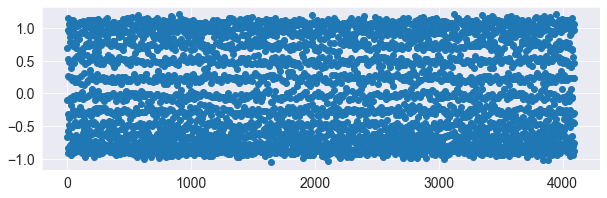

In [246]:
time = torch.linspace(1, 4096, 4096, dtype=torch.float64)
data = torch.cos(2.0*numpy.pi*0.12*time) + 0.1*torch.cos(2.0*numpy.pi*0.24*time)
data.add_(0.05*torch.randn(4096, dtype=torch.float64))
plt.figure(figsize=(10, 3))
plt.scatter(time, data)
plt.show()

In [260]:
series = pd.Series(data[:1024])
model = AutoReg(series, 128, trend='n', old_names=False)
out = model.fit()
print(res.summary())
reg = out.predict(512, 4096, dynamic=True)

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Tue, 16 Nov 2021   AIC                           5996.884
Time:                        15:56:51   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.573      1.961      0.050       0.000       2.245
HOUSTNSA.L1     0.1910      0.036      5.235      0.000       0.120       0.263
HOUSTNSA.L2     0.0058      0.037      0.155    

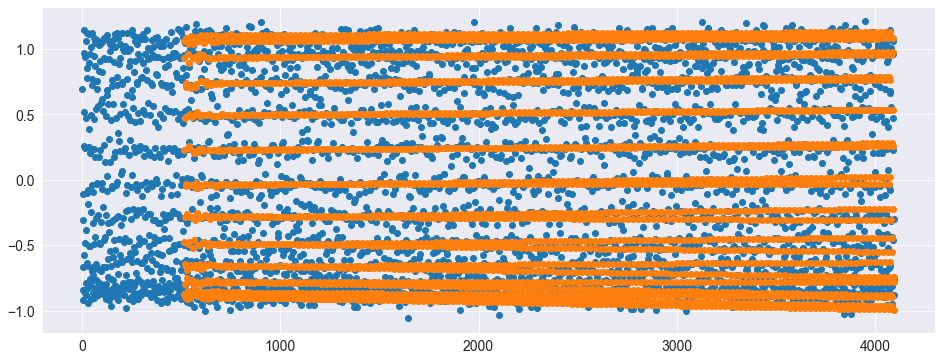

In [261]:
plt.scatter(time, data)
plt.scatter(reg.index, reg)
plt.show()

In [262]:
length = len(reg)
signal = torch.tensor(numpy.array(reg), dtype=torch.float64).unsqueeze(0)

win = Window.from_cosine(length, 1.0, dtype=torch.float64)
tbt = Data.from_tensor(win, signal)

f = Frequency(tbt)
f('parabola')
f.frequency - 0.12

tensor([-1.659524807546e-06], dtype=torch.float64)

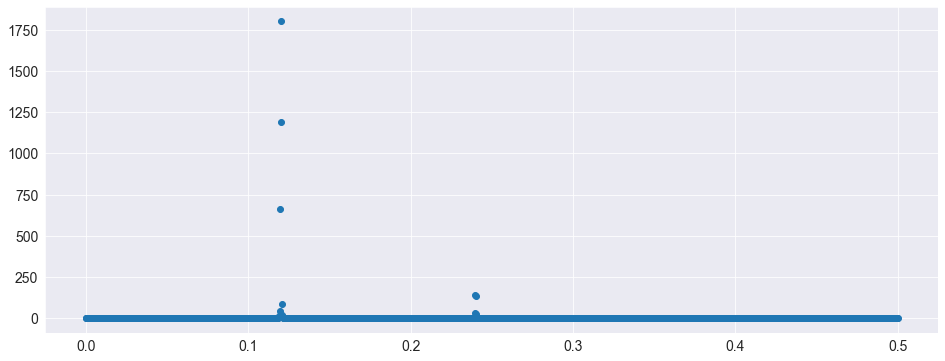

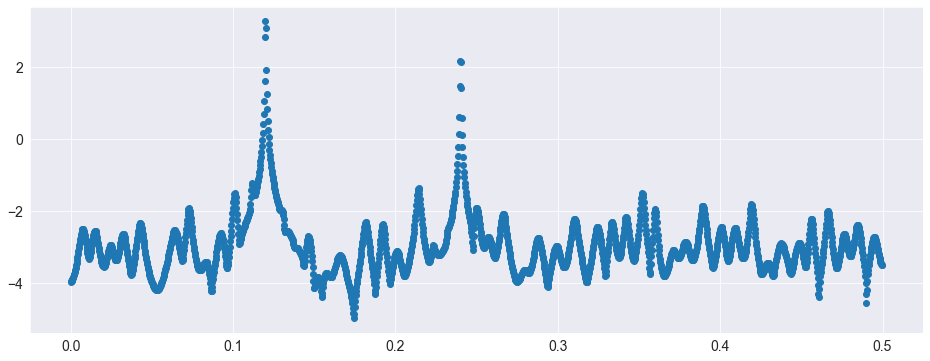

In [263]:
plt.scatter(f.fft_grid, f.fft_spectrum[0])
plt.show()
plt.scatter(f.fft_grid, torch.log10(f.fft_spectrum[0]))
plt.show()

In [ ]:
need more tests, looks like can be used against dec, for super
dmd might be better

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [20]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

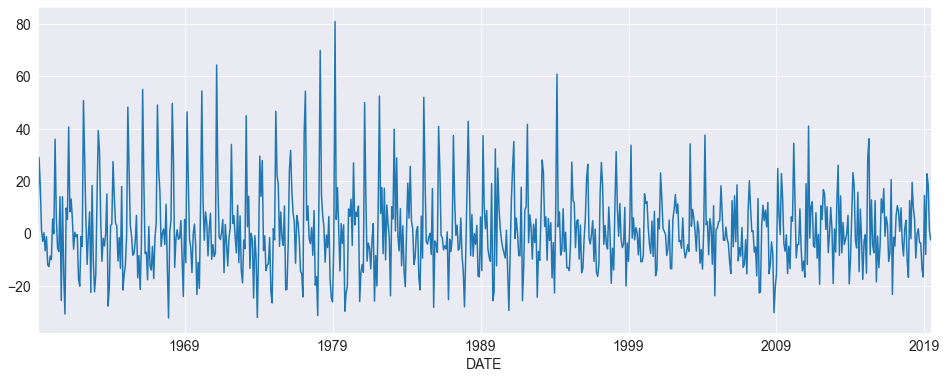

In [21]:
data = pdr.get_data_fred("HOUSTNSA", "1959-01-01", "2019-06-01")
housing = data.HOUSTNSA.pct_change().dropna()
# Scale by 100 to get percentages
housing = 100 * housing.asfreq("MS")
fig, ax = plt.subplots()
ax = housing.plot(ax=ax)

In [22]:
mod = AutoReg(housing, 3, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Tue, 16 Nov 2021   AIC                           5996.884
Time:                        15:28:15   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.573      1.961      0.050       0.000       2.245
HOUSTNSA.L1     0.1910      0.036      5.235      0.000       0.120       0.263
HOUSTNSA.L2     0.0058      0.037      0.155    

In [8]:
sel = ar_select_order(housing, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())


                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                    AutoReg(13)   Log Likelihood               -2676.157
Method:               Conditional MLE   S.D. of innovations             10.378
Date:                Tue, 16 Nov 2021   AIC                           5382.314
Time:                        15:23:05   BIC                           5450.835
Sample:                    03-01-1960   HQIC                          5408.781
                         - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.3615      0.458      2.970      0.003       0.463       2.260
HOUSTNSA.L1     -0.2900      0.036     -8.161      0.000      -0.360      -0.220
HOUSTNSA.L2     -0.0828      0.031     -2.65

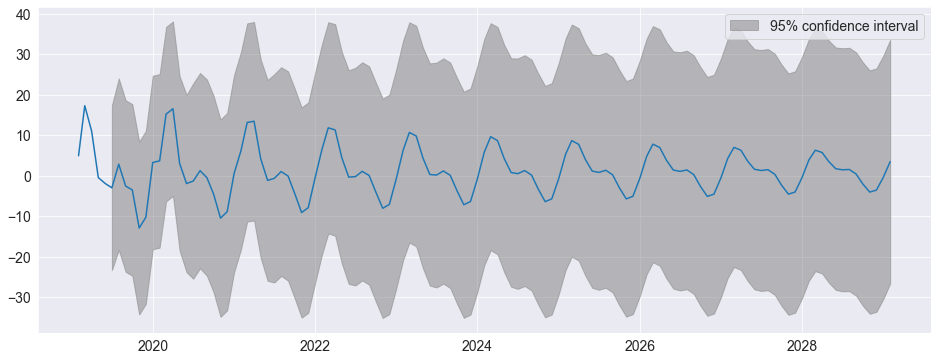

In [9]:
fig = res.plot_predict(720, 840)

# Fit (ls, pinv) + error prop (better see example in frequency for error)

In [2]:
# Import

import numpy
import torch

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [83]:
# Cosine and sine amplitudes estimation (spread from several measurements)

def fit(tbt: 'Data', frequency:float, /, *, window=False, pinv=False, ls=False) -> tuple:
    dtype = tbt.dtype
    device = tbt.device
    time = torch.linspace(1, tbt.length, tbt.length, dtype=dtype, device=device)
    
    if pinv:
        c = torch.cos(2.0*numpy.pi*time*frequency)
        s = torch.sin(2.0*numpy.pi*time*frequency)
        A = torch.stack([c, s]).T
        B = tbt.work
        c, s = (torch.pinverse(A) @ B.T)
        return c, s
    
    if ls:
        c = torch.cos(2.0*numpy.pi*time*frequency)
        s = torch.sin(2.0*numpy.pi*time*frequency)
        A = torch.stack([c, s]).T
        B = tbt.work
        c, s = (torch.linalg.lstsq(A, B.T).solution)
        return c, s
    
    if window:
        c = 1.0/tbt.window.total*torch.sum(2.0*tbt.window.data*tbt.work*torch.cos(2.0*numpy.pi*time*frequency), 1)
        s = 1.0/tbt.window.total*torch.sum(2.0*tbt.window.data*tbt.work*torch.sin(2.0*numpy.pi*time*frequency), 1)
    else:
        c = 1.0/tbt.length*torch.sum(2.0*tbt.work*torch.cos(2.0*numpy.pi*time*frequency), 1)
        s = 1.0/tbt.length*torch.sum(2.0*tbt.work*torch.sin(2.0*numpy.pi*time*frequency), 1)
        
    return c, s

def task(limit: int, length:int, frequency:float, /, *, window=False, method=None, ls=False, pinv=False) -> tuple:
        
    lc = []
    ls = []
    
    for _ in range(limit):
        tbt = load(length, std)
        flt = Filter(tbt, random_seed=seed)
        
        if method == 'svd':
            flt.filter_svd(rank=2, cpu=True)
        
        if method == 'hankel':
            flt.filter_svd(rank=2, cpu=True)
            flt.filter_hankel(rank=2, cpu=True, random=True, buffer=8, count=16)
            
        c, s = fit(tbt, f_ref, window=window, ls=ls)
        lc.append(c)
        ls.append(s)
        
    lc = torch.stack(lc).T
    ls = torch.stack(ls).T
    return lc, ls

In [785]:
std = 0.1
length = 1024
interval = torch.linspace(start=1.0, end=length, steps=length, dtype=torch.float64)
signal = 1.0 * torch.cos(2.0 * numpy.pi * 0.12 * interval + 0.75)
signal.requires_grad_(True)


def get_amplitude(length, frequency, interval, signal):
    c = torch.cos(2.0 * numpy.pi * frequency * interval)
    s = torch.sin(2.0 * numpy.pi * frequency * interval)
    c = 2.0 * torch.dot(c, signal)
    s = 2.0 * torch.dot(s, signal)
    return torch.sqrt(c*c + s*s) / length

amplitude = get_amplitude(length, 0.12, interval, signal)
print(amplitude.item())
amplitude.backward()

sigma = std**2 + torch.zeros(length, dtype=torch.float64)
sigma = torch.diag(sigma)
print(torch.sqrt(torch.dot(sigma @ signal.grad, signal.grad)).item())

signal.grad = None

def get_phase(length, frequency, interval, signal):
    c = torch.cos(2.0 * numpy.pi * frequency * interval)
    s = torch.sin(2.0 * numpy.pi * frequency * interval)
    c = 2.0 * torch.dot(c, signal)
    s = 2.0 * torch.dot(s, signal)
    return torch.atan2(-s, c)

phase = get_phase(length, 0.12, interval, signal)
print(phase.item())
phase.backward()
print(torch.sqrt(torch.dot(sigma @ signal.grad, signal.grad)).item())

0.9999313951853441
0.004419268928967349
0.7509741831855907
0.0044198690551752705
